In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import random
from tqdm import tqdm
from tqdm import tqdm_notebook

from collections import defaultdict, namedtuple

from IPython.display import clear_output

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 14) # (w, h)

In [3]:
from mtcnn.mtcnn import MTCNN
import cvlib

class MTCNNDetector:
    """MTCNNDetector"""
    def __init__(self):
        self.model = MTCNN()
    
    def detect_faces(self, img):
        faces = self.model.detect_faces(img)
        faces = [x['box'] for x in faces]
        return faces

def rect_to_bb(rect):
    x1, y1, x2, y2 = rect
    return (x1, y1, x2-x1, y2-y1)

class CVLibDetector:
    "CVLibDetector"
    def __init__(self):
        return
    
    def detect_faces(self, img):
        face_rects, confidences = cvlib.detect_face(img)
        faces = [rect_to_bb(face_rect) for face_rect in face_rects]
        return faces

mtcnn_detector = MTCNNDetector()
cvlib_detector = CVLibDetector()
detectors = [
    (mtcnn_detector, 'cache.pickle'),
    (cvlib_detector, 'yolo_cache.pickle')
]

from keras_facenet import FaceNet
embedder = FaceNet()
clear_output()

In [4]:
face_detector, cache_file = detectors[0]
metadata_filename = 'metadata.json'
events_path = os.path.join('data', 'CVDataset')

In [5]:
from utils import load_image, load_images, load_face_information, cache_face_information, load_image, cache_face_information, use_tqdm, ImageLoader

In [133]:
def encode_face(img):
    location = locate_faces(img)[:1]
    face_img = extract_faces(img, location)
    return embedder.embeddings(face_img)[0]

def encode_faces(img, locations):
    if not len(locations):
        return np.array([])
    return embedder.embeddings(extract_faces(img, locations))

def extract_faces(img, locations):
    res_imgs = []
    for (y1, x1, y2, x2) in locations:
        res_imgs.append(img[y1:y2, x2:x1])
    return res_imgs

def draw_faces(img, locations, verbose=True, title=None):
    res_img = img.copy()
    for (y1, x1, y2, x2) in locations:
        cv2.rectangle(res_img, (x1, y2), (x2, y1), (0, 255, 0), 8)
    if verbose:
        plt.imshow(res_img)
        plt.title(title)
        plt.show()
    return res_img

def locate_faces(img):
    faces = face_detector.detect_faces(img)
    faces = [(max(y, 0),
              min(x+w, img.shape[1]),
              min(y+h, img.shape[0]),
              max(x, 0)) for x, y, w, h in faces 
             if y < img.shape[0] and x < img.shape[1]]
    return np.array(faces)

def face_distance(face1, face2):
    return np.linalg.norm(face1 - face2, axis=1)

def compare_faces(face1, face2, tolerance=None):
    tolerance = tolerance or 0.9
    return list(face_distance(face1, face2) <= tolerance)

In [413]:
class Person:
    def __init__(self, imgs, name):
        self.imgs = imgs
        self.name = name
        self.encodings = [encode_face(img).reshape(1, -1) for img in imgs]
    
    def __repr__(self):
        return f"<class Person: {self.name}>"

# Load photo with the person
people = [
    Person([load_image(os.path.join('data', img)) for img in [
                                                              'boris.jpg',
                                                              'boris_2.jpg',
#                                                               'boris_3.jpg',
#                                                               'boris_4.jpg',
#                                                              'boris_c1.jpg', 'boris_c2.jpg', 'boris_c3.jpg'
                                                             ]], 'Boris'),
    Person([load_image(os.path.join('data', img)) for img in [
                                                              'vlad.jpg',
                                                              'vlad_2.jpg',
                                                             ]], 'Vlad'),
    Person([load_image(os.path.join('data', img)) for img in ['ivan_2.jpg', 'ivan_3.jpg']], 'Ivan'),
#     Person([load_image(os.path.join('data', img)) for img in ['denis.jpg']], 'Denis'),
#     Person([load_image(os.path.join('data', img)) for img in ['andrey.jpg']] 'Andrey'),
]

person = people[0]

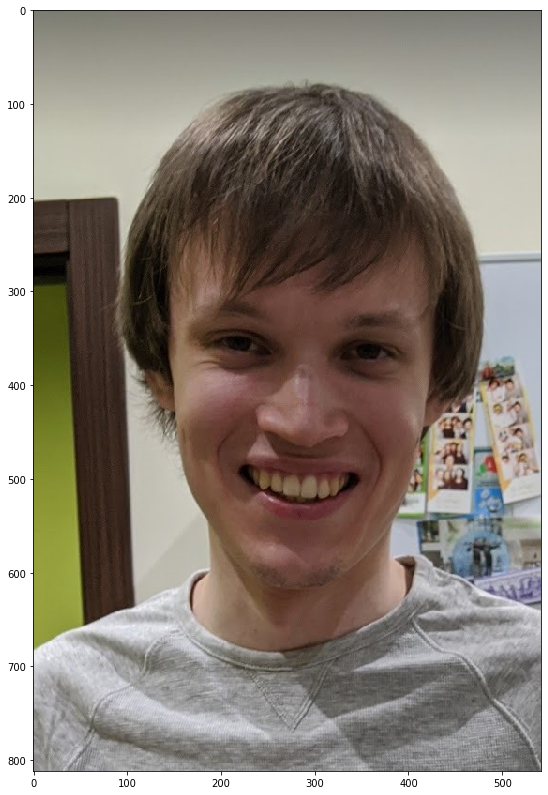

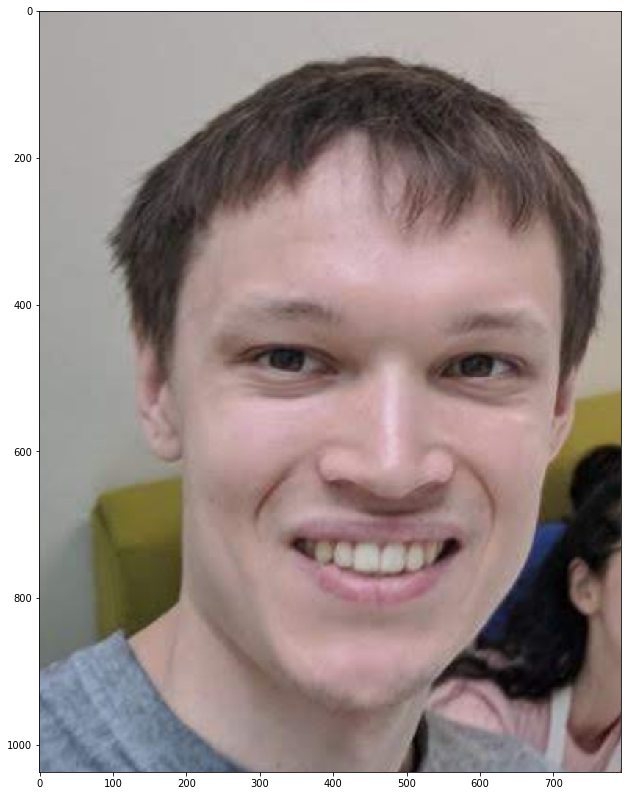

In [209]:
for img in person.imgs:
    plt.imshow(img[:, :, ::-1])
    plt.show()

In [414]:
# List folders
glob_path = os.path.join(events_path, '*')
folders = glob.glob(glob_path)
images = ImageLoader(glob_path)
folders.remove('data\\CVDataset\\Vlad')
folders.remove('data\\CVDataset\\Boris')
print(np.array(folders))

['data\\CVDataset\\23_8 InnoClubFest 2017'
 'data\\CVDataset\\Aerotube sweets'
 'data\\CVDataset\\Club Fest, Fall 2018' 'data\\CVDataset\\Halloween 2017'
 'data\\CVDataset\\Halloween 2018'
 'data\\CVDataset\\Slippers of the Year 2018'
 'data\\CVDataset\\Slippers of the Year 2019']


In [415]:
events_metadata = defaultdict(set)
for folder in folders:
    with open(os.path.join(folder, metadata_filename)) as metadata_file:
        event_metadata = json.loads(metadata_file.read())
    for k, v in event_metadata.items():
        events_metadata[k].update([os.path.join(folder, vi) for vi in v])
len(events_metadata)

4

In [416]:
list(events_metadata.keys())

['boris', 'noone', 'vlad', 'ivan']

In [417]:
def process_images(images, scale=0.5, desc="Processing faces in images"):
    """Get face locations and encodings from given images."""
    face_info = dict()
    for i, (img_name, img) in use_tqdm(enumerate(images),
                                       desc=desc,
                                       total=len(images)):
        # Scale down for faster processing
        small_img = cv2.resize(img, (0, 0), fx=scale, fy=scale)

        # Face detection
        face_locations = locate_faces(small_img)
        if len(face_locations) == 0:
            # Ignoring empty
            face_encodings = []
        else:
            # Face extraction
            face_encodings = encode_faces(small_img, face_locations)
        
        # Scale locations back
        face_locations = scale_locations(face_locations, 1 / scale)
        
        face_info[img_name] = {
            'locations': face_locations,
            'encodings': face_encodings
        }
    return face_info

def scale_locations(locations, scale=2):
    return (locations * scale).astype(int)
    for i, loc in enumerate(locations):
        for j, coord in enumerate(loc):
            locations[i, j] = int(coord * scale)
    return locations

face_info = defaultdict(dict)
for folder in folders:
    cache_path = os.path.join(folder, cache_file)
    if os.path.exists(cache_path):
        face_info[folder] = load_face_information(cache_path)
        print('Loaded cached data')
    else:
        face_info[folder] = process_images(ImageLoader(folder))
        cache_face_information(face_info[folder], cache_path)

Loaded cached data
Loaded cached data
Loaded cached data
Loaded cached data
Loaded cached data
Loaded cached data
Loaded cached data


In [418]:
def compare_img_to_set(face_encoding, face_information, tolerance=None):
    images_with_person = dict()
    for i, (img_name, face_info) in enumerate(face_information.items()):

        if len(face_info['locations']) == 0 or len(face_info['encodings']) == 0:
            continue

        matches = compare_faces(face_encoding, face_info['encodings'], tolerance)

        if any(matches):
            images_with_person[img_name] = face_info['locations'][matches]
    return images_with_person

## Compare different Face Comparison methods

In [419]:
def calc_stats(predicted, real):
    precision = len(real.intersection(predicted)) / len(predicted) if len(predicted) else 0.
    recall = len(real.intersection(predicted)) / len(real) if len(real) else 0.
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.
    return precision, recall, f1_score

def get_stats(results, person_name, verbose=True):
    img_paths = list(map(os.path.normpath, results))
    prec, recall, f1_score = calc_stats(img_paths, events_metadata[person_name.lower()])
    if verbose:
        print(f"""Found {len(results)} images with {person_name}.
        Precision: {prec: <4.3}
        Recall:    {recall: <4.3}
        F1-Score:  {f1_score: <4.3}
        """)
    return img_paths, prec, recall, f1_score

def get_mean_stats(results, verbose=True):
    mean_prec = np.mean(list(map(lambda x: x['prec'], results)))
    mean_recall = np.mean(list(map(lambda x: x['recall'], results)))
    mean_f1_score = np.mean(list(map(lambda x: x['f1_score'], results)))
    if verbose:
        print(f"Mean precision: {mean_prec: <4.3}\n" +
              f"Mean recall:    {mean_recall: <4.3}\n"  +
              f"Mean f1-score:  {mean_f1_score: <.3}")
    return mean_prec, mean_recall, mean_f1_score

### Union of recognition
взяты все фото для 2х лиц одного человека (union)

In [420]:
def fd_union_of_results(people, folders, face_info, verbose=True, tolerance=None):
    results = []
    for person in people:
        result = dict()
        for folder in folders:
            for encoding in person.encodings:
                result.update(compare_img_to_set(encoding, face_info[folder], tolerance=tolerance))

        img_paths, acc, recall, f1_score = get_stats(result, person.name, verbose=verbose)
        results.append({'res':result, 'prec':acc, 'recall':recall, 'f1_score':f1_score})
    return results

results = fd_union_of_results(people, folders, face_info)
_ = get_mean_stats(results)

Found 46 images with Boris.
        Precision: 0.696
        Recall:    0.696
        F1-Score:  0.696
        
Found 15 images with Vlad.
        Precision: 0.867
        Recall:    0.591
        F1-Score:  0.703
        
Found 61 images with Ivan.
        Precision: 0.0328
        Recall:    0.5 
        F1-Score:  0.0615
        
Mean precision: 0.532
Mean recall:    0.596
Mean f1-score:  0.487


### Intersection of recognition
взяты общие фото для 2х лиц одного человека (intersection)

In [421]:
def fd_inter_of_results(people, folders, face_info, verbose=True, tolerance=None):
    results = []
    for person in people:
        common = None
        for encoding in person.encodings:
            result = dict()
            for folder in folders:
                result.update(compare_img_to_set(encoding, face_info[folder], tolerance=tolerance))
            if common is None:
                common = set(result.keys())
            else:
                common.intersection_update(set(result.keys()))

        # filter results
        tmp = dict()
        for k in common:
            tmp[k] = result[k]
        result = tmp

        img_paths, acc, recall, f1_score = get_stats(result, person.name, verbose=verbose)
        results.append({'res':result, 'prec':acc, 'recall':recall, 'f1_score':f1_score})
    return results


results = fd_inter_of_results(people, folders, face_info)
_ = get_mean_stats(results)

Found 32 images with Boris.
        Precision: 0.906
        Recall:    0.63
        F1-Score:  0.744
        
Found 7 images with Vlad.
        Precision: 1.0 
        Recall:    0.318
        F1-Score:  0.483
        
Found 0 images with Ivan.
        Precision: 0.0 
        Recall:    0.0 
        F1-Score:  0.0 
        
Mean precision: 0.635
Mean recall:    0.316
Mean f1-score:  0.409


### Mean vector
взят средний вектор

In [422]:
def fd_mean_emb_vec(people, folders, face_info, verbose=True, tolerance=None):
    results = []
    for person in people:
        mean_encoding = np.array(person.encodings).mean(axis=0)
        result = dict()
        for folder in folders:
            result.update(compare_img_to_set(mean_encoding, face_info[folder], tolerance=tolerance))

        img_paths, acc, recall, f1_score = get_stats(result, person.name, verbose=verbose)
        results.append({'res':result, 'prec':acc, 'recall':recall, 'f1_score':f1_score})
    return results

results = fd_mean_emb_vec(people, folders, face_info)
_ = get_mean_stats(results)

Found 56 images with Boris.
        Precision: 0.607
        Recall:    0.739
        F1-Score:  0.667
        
Found 31 images with Vlad.
        Precision: 0.548
        Recall:    0.773
        F1-Score:  0.642
        
Found 45 images with Ivan.
        Precision: 0.0444
        Recall:    0.5 
        F1-Score:  0.0816
        
Mean precision: 0.4 
Mean recall:    0.671
Mean f1-score:  0.463


## Grid search for `T`

In [470]:
from sklearn.model_selection import ParameterGrid
from itertools import combinations

boris_photos = ['boris.jpg', 'boris_2.jpg', 'boris_3.jpg', 'boris_4.jpg']

vlad_photos = ['vlad.jpg', 'vlad_2.jpg', 'vlad_3.jpg', 'vlad_4.jpg']

ivan_photos = ['ivan_2.jpg','ivan_3.jpg']

def get_params(sample_size):
    params = {
        'boris': list(combinations(boris_photos, sample_size)),
        'vlad': list(combinations(vlad_photos,   sample_size)),
    #     'ivan': list(combinations(ivan_photos, sample_size)),
    }
    return ParameterGrid(params)

In [505]:
grid_search_res = []

for sample_size in [1, 2, 3]:
    param_grid = get_params(sample_size)
    print(f'Sample size {sample_size}')
    ss_gs_res = []
    for params in tqdm_notebook(param_grid):
        people = [
                  Person([load_image(os.path.join('data', img)) for img in params['boris']], 'Boris'),
                  Person([load_image(os.path.join('data', img)) for img in params['vlad']], 'Vlad'),
        ]
        best_score = [0]
        for T in np.arange(0.6, 1.2, 0.01):
            for i, (f_name, f) in enumerate(face_detec_funcs.items()):
                results = f(people, folders, face_info, verbose=False, tolerance=T)
                mean_prec, mean_recall, mean_f1_score = get_mean_stats(results, verbose=False)
                if mean_f1_score > best_score[0]:
                    # f1-score, prec, recall, T, f_ind
                    best_score = [mean_f1_score, mean_prec, mean_recall, T, i]
#                     {'val':mean_f1_score,
#                                   'prec':mean_prec,
#                                   'recall':mean_recall,
#                                   'params':{'T':T, 'f':f_name}}
        ss_gs_res.append(best_score)
    grid_search_res.append(np.array(ss_gs_res))

grid_search_res = np.array(grid_search_res)

Sample size 1


Sample size 2


Sample size 3


In [507]:
compare_func = np.mean
(
    ('T', 
     compare_func(grid_search_res[0][:, 3]),
     compare_func(grid_search_res[1][:, 3]),
     compare_func(grid_search_res[2][:, 3]),
    ),
    ('f1-score',
     compare_func(grid_search_res[0][:, 0]),
     compare_func(grid_search_res[1][:, 0]),
     compare_func(grid_search_res[2][:, 0]),
    ),
)

(('T', 0.9106250000000002, 0.8800000000000003, 0.8337500000000002),
 ('f1-score', 0.5919925516775766, 0.6769146847630476, 0.6899608309793609))

### Calculate mean stats

In [508]:
scores = []

# Optimal T for different sample sizes
T = [0.9106250000000002, 0.8800000000000003, 0.8337500000000002]

for sample_size in [1, 2, 3]:
    param_grid = get_params(sample_size)
    print(f'Sample size {sample_size}')
    ss_scores = []
    
    for params in tqdm_notebook(param_grid):
        people = [
                  Person([load_image(os.path.join('data', img)) for img in params['boris']], 'Boris'),
                  Person([load_image(os.path.join('data', img)) for img in params['vlad']], 'Vlad'),
    #               Person([load_image(os.path.join('data', img)) for img in params['ivan']], 'Ivan'),
        ]
        score = []
        for f_name, f in face_detec_funcs.items():
            results = f(people, folders, face_info, verbose=False, tolerance=T[sample_size - 1])
            mean_prec, mean_recall, mean_f1_score = get_mean_stats(results, verbose=False)
            score.append([mean_prec, mean_recall, mean_f1_score])
        ss_scores.append(score)
    scores.append(np.array(ss_scores))

scores = np.array(scores)

Sample size 1


Sample size 2


Sample size 3


In [509]:
list(face_detec_funcs.keys())

['union', 'inter', 'mean']

In [514]:
func = lambda x: np.mean(x, 0)
(func(np.array(scores)[2][:, 0, :]),
 func(np.array(scores)[2][:, 1, :]),
 func(np.array(scores)[2][:, 2, :]),)

(array([0.8002583 , 0.51951581, 0.62335273]),
 array([0.625     , 0.20676877, 0.29730535]),
 array([0.76158234, 0.59807312, 0.66345574]))

## Show results
Here a two random images from two sets:
* Found mages with *person* - found with our system and this person is actually there (**True Positive**)
* Found images withour *person* - found with our system, but this person isn't on it (**False Positive**)
* Not found with *person* - not found with our system, but person on it (**False Negative**)

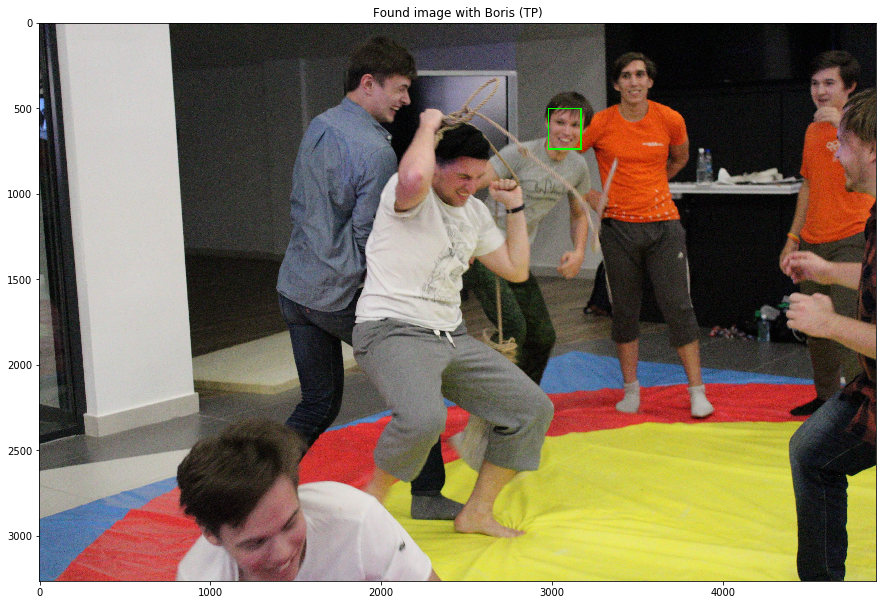

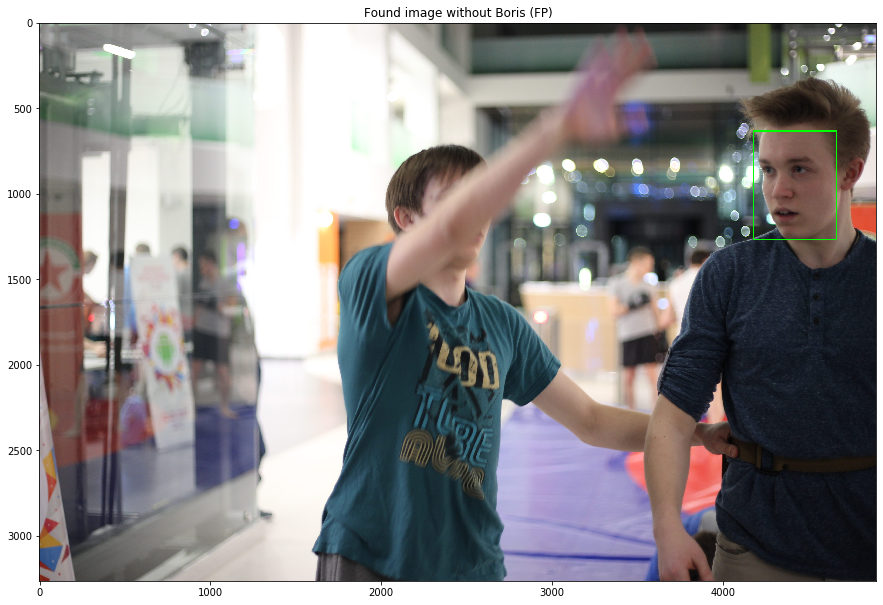

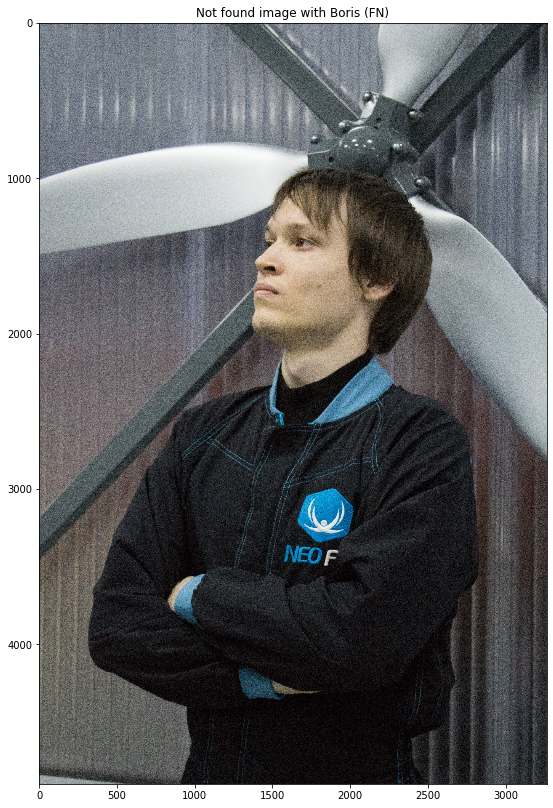

In [118]:
people_ind = 0
result = results[people_ind]['res']
person = people[people_ind]
tp_results = list(events_metadata[person.name.lower()].intersection(result))
fn_results = list(events_metadata[person.name.lower()].difference(result))
fp_results = list(set(result).difference(events_metadata[person.name.lower()]))

if len(tp_results):
    image_path = random.choice(tp_results)
    face_loc = result[image_path]
    img = load_image(image_path)[:, :, ::-1]
    draw_faces(img, face_loc, title=f'Found image with {person.name} (TP)')
else:
    print('No images found', person.name)


if len(fp_results): 
    image_path = random.choice(fp_results)
    face_loc = result[image_path]
    img = load_image(image_path)[:, :, ::-1]
    draw_faces(img, face_loc, title=f'Found image without {person.name} (FP)')
else:
    print('No false positives', person.name)

if len(fn_results): 
    image_path = random.choice(fn_results)
    img = load_image(image_path)[:, :, ::-1]
    draw_faces(img, [], title=f'Not found image with {person.name} (FN)')
else:
    print('No false negatives', person.name)